In [197]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import os

from pymystem3 import Mystem

import nltk
from nltk.tokenize import word_tokenize
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split



Хорошая функция лемматизации (работает с русским языком - УРАААА), но нет предела совершенству - выполняется для 2000 отзывов 35 минут...

In [198]:

def Lemmatize(src: list):
    ''' Лемматизирует переданный датасет
    '''
    text_nomalized = ' '.join(src).lower() 

    m = Mystem()
    lemmas = m.lemmatize(text_nomalized)
    
    return lemmas

# Пункт 1

Необходимо загрузить исходный набор данных и соответствующие метки классов.

In [199]:
data = pd.read_csv('dataframe.csv')

#data = data.head(5)
data.head()
#data = data.head(10)
#«Обучающая выборка» — это набор данных, который используется для разработки модели машинного обучения.

#«Валидационная выборка» — это набор данных, который используется в процессе разработки модели машинного обучения для подбора оптимального набора гиперпараметров.

#«Тестовая выборка» — это набор данных, который не используется непосредственно в процессе обучения модели или для подбора гиперпараметров, 
# однако позволяет протестировать модель и является контрольным.

,class_mark,text_review
0,good,Зеленая миля\n'Они помогли ему убить себя и та...
1,good,"Зеленая миля\n'Боже, иногда Зеленая миля так д..."
2,good,Зеленая миля\nОни помогли ему убить себя\n\n«О...
3,good,Зеленая миля\n«Когда призовет Господь на свой ...
4,good,Зеленая миля\nОбвиненный в страшном преступлен...


Изменяем метки класса: если отзыв хороший, то записываем 1, иначе - 0

In [200]:
data.dropna(inplace=True)
change_labels = lambda x: 1 if x=='good' else 0
data['class_mark'] = data['class_mark'].apply(change_labels)
data.head()

,class_mark,text_review
0,1,Зеленая миля\n'Они помогли ему убить себя и та...
1,1,"Зеленая миля\n'Боже, иногда Зеленая миля так д..."
2,1,Зеленая миля\nОни помогли ему убить себя\n\n«О...
3,1,Зеленая миля\n«Когда призовет Господь на свой ...
4,1,Зеленая миля\nОбвиненный в страшном преступлен...


Дурацкий лемматинайзер - не работает с русскими словами

In [201]:
lemmatizer = WordNetLemmatizer()
leammtizer = lambda x: [ lemmatizer.lemmatize(word) for word in x ]

In [202]:
# data.dropna(inplace=True)
remove_non_alphabets = lambda x: re.sub(r'[^а-яА-Я]',' ',str(x))

tokenize = lambda x: word_tokenize(x, language = "russian")

ps = PorterStemmer()
stem = lambda w: [ ps.stem(x) for x in w ]

print('remove_non_alphabets')
data['text_review'] = data['text_review'].apply(remove_non_alphabets)

print('tokenize')
data['text_review'] = data['text_review'].apply(tokenize) # [ word_tokenize(row) for row in data['email']]

print('stem')
data['text_review'] = data['text_review'].apply(stem)

print('Lemmatize')
c = 0
for words_list in data['text_review']:
    words_list = Lemmatize(words_list)
    
    print(c)
    c+=1

print('complete')
data['text_review'] = data['text_review'].apply(lambda x: ' '.join(x))

data.dropna(inplace=True)

data.head()



remove_non_alphabets
tokenize
stem
Lemmatize
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
2

,class_mark,text_review
0,1,зеленая миля они помогли ему убить себя и так ...
1,1,зеленая миля боже иногда зеленая миля так длин...
2,1,зеленая миля они помогли ему убить себя они по...
3,1,зеленая миля когда призовет господь на свой су...
4,1,зеленая миля обвиненный в страшном преступлени...


# Пункт 4

Описать пайплайн предобработки данных. ВАЖНО: что так как ваш вариант предполагает работу с текстом, то необходимо выполниить векторизацию данных (подробности в туториале).

In [203]:
max_words = 10000
stopWords = stopwords.words('russian')

vectorizer = CountVectorizer(max_features=max_words,stop_words=stopWords)
sparse_matrix = vectorizer.fit_transform(data['text_review']).toarray()
print(sparse_matrix)
sparse_matrix.shape

[[0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


(2000, 10000)

In [204]:
x_train, x_test, y_train, y_test = train_test_split(sparse_matrix, np.array(data['class_mark']), test_size = 0.1, train_size= 0.8)

In [205]:
class LogisticRegression(nn.Module):
    def __init__(self):
        super(LogisticRegression, self).__init__()
        self.linear1 = nn.Linear(10000, 100)
        self.linear2 = nn.Linear(100, 10)
        self.linear3 = nn.Linear(10, 2)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [206]:
model = LogisticRegression()

In [207]:
x_train = Variable(torch.from_numpy(x_train)).float()
y_train = Variable(torch.from_numpy(y_train)).long()

In [208]:
epochs = 9
criterion = nn.CrossEntropyLoss()
model.train()
loss_values = []
i = 0.01
for epoch in range(epochs):
    
    optimizer = torch.optim.Adam(params=model.parameters() , lr=i)
    optimizer.zero_grad()
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    loss_values.append(loss.item())
    pred = torch.max(y_pred, 1)[1].eq(y_train).sum()
    acc = pred * 100.0 / len(x_train)
    print('Epoch: {}, Loss: {}, Accuracy: {}%'.format(epoch+1, loss.item(), acc.numpy()))
    loss.backward()
    if epoch%3 ==0:
        i += 0.2
    optimizer.step()

Epoch: 1, Loss: 0.6953372359275818, Accuracy: 50.1875%
Epoch: 2, Loss: 0.5595706701278687, Accuracy: 96.6875%
Epoch: 3, Loss: 116.5, Accuracy: 49.6875%
Epoch: 4, Loss: 1452.0223388671875, Accuracy: 50.3125%
Epoch: 5, Loss: 181.82965087890625, Accuracy: 50.3125%
Epoch: 6, Loss: 4.996949195861816, Accuracy: 49.625%
Epoch: 7, Loss: 18.459083557128906, Accuracy: 50.3125%
Epoch: 8, Loss: 9.444803237915039, Accuracy: 49.6875%
Epoch: 9, Loss: 0.6933376789093018, Accuracy: 50.3125%


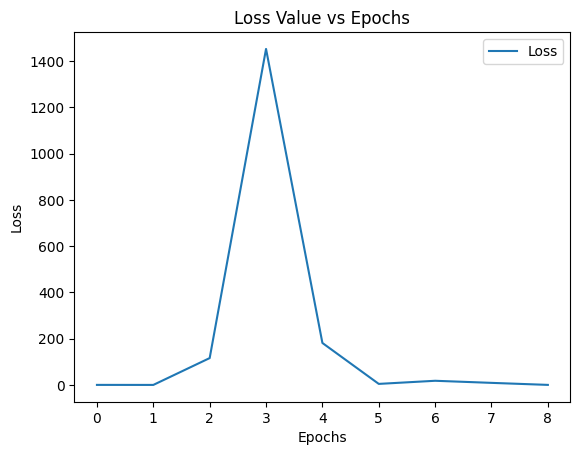

In [209]:
plt.plot(loss_values)
plt.title('Loss Value vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Loss'])
plt.show()

In [210]:
x_test = Variable(torch.from_numpy(x_test)).float()
y_test = Variable(torch.from_numpy(y_test)).long()

In [1]:
model.eval()
with torch.no_grad():
    y_pred = model(x_test)
    loss = criterion(y_pred, y_test)
    pred = torch.max(y_pred, 1)[1].eq(y_test).sum()
    
    print ("Accuracy : {}%".format(100*pred/len(x_test)))

NameError: name 'model' is not defined